In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [36]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomRotation(15),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#                                        ])


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


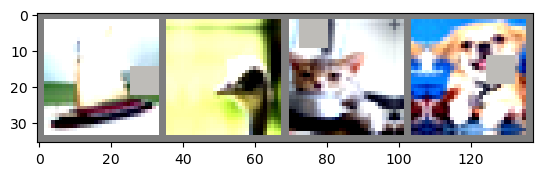

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, groups=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, 
                out_channels=64, 
                kernel_size=(3,3), 
                padding=2, 
                stride=2, 
                dilation=2, 
                bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, groups=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      padding=2, 
                      dilation=2,
                      stride=2, 
                      bias=False),
        ) # output_size = 8/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups = 64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64,  out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6          [-1, 128, 32, 32]           4,096
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 16, 16]          73,728
           Conv2d-11           [-1, 64, 16, 16]             576
           Conv2d-12          [-1, 128, 16, 16]           8,192
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1,

You should consider upgrading via the 'I:\Installs\python.exe -m pip install --upgrade pip' command.


In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]

Loss=1.5938913822174072 Batch_id=97 Accuracy=31.25: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 1.6163, Accuracy: 3995/10000 (39.95%)

EPOCH: 1


Loss=1.4642003774642944 Batch_id=97 Accuracy=46.25: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 1.3231, Accuracy: 5156/10000 (51.56%)

EPOCH: 2


Loss=1.2435015439987183 Batch_id=97 Accuracy=53.36: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]



Test set: Average loss: 1.1749, Accuracy: 5809/10000 (58.09%)

EPOCH: 3


Loss=1.0438508987426758 Batch_id=97 Accuracy=58.43: 100%|██████████| 98/98 [00:13<00:00,  7.24it/s]



Test set: Average loss: 1.0449, Accuracy: 6238/10000 (62.38%)

EPOCH: 4


Loss=1.1010385751724243 Batch_id=97 Accuracy=61.22: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]



Test set: Average loss: 0.9762, Accuracy: 6498/10000 (64.98%)

EPOCH: 5


Loss=1.0104234218597412 Batch_id=97 Accuracy=63.15: 100%|██████████| 98/98 [00:11<00:00,  8.22it/s]



Test set: Average loss: 0.9214, Accuracy: 6671/10000 (66.71%)

EPOCH: 6


Loss=1.0122969150543213 Batch_id=97 Accuracy=65.47: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Test set: Average loss: 0.9024, Accuracy: 6788/10000 (67.88%)

EPOCH: 7


Loss=0.9157723188400269 Batch_id=97 Accuracy=66.86: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]



Test set: Average loss: 0.8340, Accuracy: 7054/10000 (70.54%)

EPOCH: 8


Loss=0.8863223791122437 Batch_id=97 Accuracy=68.14: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 0.7798, Accuracy: 7300/10000 (73.00%)

EPOCH: 9


Loss=0.8446061015129089 Batch_id=97 Accuracy=69.73: 100%|██████████| 98/98 [00:12<00:00,  7.71it/s]



Test set: Average loss: 0.7529, Accuracy: 7397/10000 (73.97%)

EPOCH: 10


Loss=0.8193402290344238 Batch_id=97 Accuracy=70.87: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]



Test set: Average loss: 0.7364, Accuracy: 7407/10000 (74.07%)

EPOCH: 11


Loss=0.7291877865791321 Batch_id=97 Accuracy=71.68: 100%|██████████| 98/98 [00:11<00:00,  8.46it/s]



Test set: Average loss: 0.7025, Accuracy: 7578/10000 (75.78%)

EPOCH: 12


Loss=0.7293088436126709 Batch_id=97 Accuracy=72.68: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s]



Test set: Average loss: 0.7081, Accuracy: 7532/10000 (75.32%)

EPOCH: 13


Loss=0.6605973243713379 Batch_id=97 Accuracy=73.48: 100%|██████████| 98/98 [00:11<00:00,  8.32it/s]



Test set: Average loss: 0.6684, Accuracy: 7679/10000 (76.79%)

EPOCH: 14


Loss=0.7200950384140015 Batch_id=97 Accuracy=74.04: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]



Test set: Average loss: 0.6332, Accuracy: 7750/10000 (77.50%)

EPOCH: 15


Loss=0.7732340693473816 Batch_id=97 Accuracy=74.71: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]



Test set: Average loss: 0.6379, Accuracy: 7784/10000 (77.84%)

EPOCH: 16


Loss=0.7403805255889893 Batch_id=97 Accuracy=75.30: 100%|██████████| 98/98 [00:11<00:00,  8.38it/s]



Test set: Average loss: 0.6386, Accuracy: 7807/10000 (78.07%)

EPOCH: 17


Loss=0.6598532199859619 Batch_id=97 Accuracy=75.56: 100%|██████████| 98/98 [00:11<00:00,  8.45it/s]



Test set: Average loss: 0.6314, Accuracy: 7835/10000 (78.35%)

EPOCH: 18


Loss=0.685737133026123 Batch_id=97 Accuracy=76.26: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s] 



Test set: Average loss: 0.6172, Accuracy: 7882/10000 (78.82%)

EPOCH: 19


Loss=0.5705410242080688 Batch_id=97 Accuracy=77.18: 100%|██████████| 98/98 [00:11<00:00,  8.26it/s]



Test set: Average loss: 0.6087, Accuracy: 7896/10000 (78.96%)

EPOCH: 20


Loss=0.7721759080886841 Batch_id=97 Accuracy=77.04: 100%|██████████| 98/98 [00:13<00:00,  7.30it/s]



Test set: Average loss: 0.5756, Accuracy: 8029/10000 (80.29%)

EPOCH: 21


Loss=0.5492364764213562 Batch_id=97 Accuracy=77.73: 100%|██████████| 98/98 [00:11<00:00,  8.33it/s]



Test set: Average loss: 0.5594, Accuracy: 8088/10000 (80.88%)

EPOCH: 22


Loss=0.6762881278991699 Batch_id=97 Accuracy=77.82: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]



Test set: Average loss: 0.5574, Accuracy: 8058/10000 (80.58%)

EPOCH: 23


Loss=0.5607526898384094 Batch_id=97 Accuracy=78.29: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]



Test set: Average loss: 0.5938, Accuracy: 7983/10000 (79.83%)

EPOCH: 24


Loss=0.6173791885375977 Batch_id=97 Accuracy=78.73: 100%|██████████| 98/98 [00:11<00:00,  8.46it/s]



Test set: Average loss: 0.5462, Accuracy: 8153/10000 (81.53%)

EPOCH: 25


Loss=0.6635943055152893 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Test set: Average loss: 0.5246, Accuracy: 8198/10000 (81.98%)

EPOCH: 26


Loss=0.6032050251960754 Batch_id=97 Accuracy=79.29: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s] 



Test set: Average loss: 0.5171, Accuracy: 8249/10000 (82.49%)

EPOCH: 27


Loss=0.566018283367157 Batch_id=97 Accuracy=79.40: 100%|██████████| 98/98 [00:11<00:00,  8.77it/s] 



Test set: Average loss: 0.5288, Accuracy: 8155/10000 (81.55%)

EPOCH: 28


Loss=0.5335061550140381 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:11<00:00,  8.68it/s]



Test set: Average loss: 0.5261, Accuracy: 8210/10000 (82.10%)

EPOCH: 29


Loss=0.5727697014808655 Batch_id=97 Accuracy=80.13: 100%|██████████| 98/98 [00:13<00:00,  7.22it/s] 



Test set: Average loss: 0.5263, Accuracy: 8212/10000 (82.12%)

EPOCH: 30


Loss=0.530617892742157 Batch_id=97 Accuracy=80.29: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]  



Test set: Average loss: 0.5272, Accuracy: 8225/10000 (82.25%)

EPOCH: 31


Loss=0.5487827658653259 Batch_id=97 Accuracy=80.51: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s] 



Test set: Average loss: 0.5158, Accuracy: 8284/10000 (82.84%)

EPOCH: 32


Loss=0.5386143922805786 Batch_id=97 Accuracy=80.95: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s] 



Test set: Average loss: 0.4998, Accuracy: 8319/10000 (83.19%)

EPOCH: 33


Loss=0.6247193813323975 Batch_id=97 Accuracy=81.19: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s] 



Test set: Average loss: 0.5073, Accuracy: 8293/10000 (82.93%)

EPOCH: 34


Loss=0.491117388010025 Batch_id=97 Accuracy=81.30: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]  



Test set: Average loss: 0.4968, Accuracy: 8333/10000 (83.33%)

EPOCH: 35


Loss=0.555752158164978 Batch_id=97 Accuracy=81.58: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]  



Test set: Average loss: 0.4914, Accuracy: 8343/10000 (83.43%)

EPOCH: 36


Loss=0.5638745427131653 Batch_id=97 Accuracy=81.58: 100%|██████████| 98/98 [00:12<00:00,  8.06it/s] 



Test set: Average loss: 0.4712, Accuracy: 8441/10000 (84.41%)

EPOCH: 37


Loss=0.5040097236633301 Batch_id=97 Accuracy=82.06: 100%|██████████| 98/98 [00:11<00:00,  8.26it/s] 



Test set: Average loss: 0.4565, Accuracy: 8472/10000 (84.72%)

EPOCH: 38


Loss=0.49843543767929077 Batch_id=97 Accuracy=82.18: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]



Test set: Average loss: 0.4653, Accuracy: 8415/10000 (84.15%)

EPOCH: 39


Loss=0.5320570468902588 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s] 



Test set: Average loss: 0.4574, Accuracy: 8485/10000 (84.85%)

EPOCH: 40


Loss=0.552270770072937 Batch_id=97 Accuracy=82.47: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s]  



Test set: Average loss: 0.4798, Accuracy: 8373/10000 (83.73%)

EPOCH: 41


Loss=0.5134892463684082 Batch_id=97 Accuracy=82.53: 100%|██████████| 98/98 [00:11<00:00,  8.27it/s] 



Test set: Average loss: 0.4842, Accuracy: 8393/10000 (83.93%)

EPOCH: 42


Loss=0.4878634512424469 Batch_id=97 Accuracy=82.66: 100%|██████████| 98/98 [00:11<00:00,  8.38it/s] 



Test set: Average loss: 0.4439, Accuracy: 8523/10000 (85.23%)

EPOCH: 43


Loss=0.5141604542732239 Batch_id=97 Accuracy=82.73: 100%|██████████| 98/98 [00:11<00:00,  8.49it/s] 



Test set: Average loss: 0.4406, Accuracy: 8523/10000 (85.23%)

EPOCH: 44


Loss=0.5114307999610901 Batch_id=97 Accuracy=83.04: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s] 



Test set: Average loss: 0.4738, Accuracy: 8423/10000 (84.23%)

EPOCH: 45


Loss=0.5643962025642395 Batch_id=97 Accuracy=83.34: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s] 



Test set: Average loss: 0.4349, Accuracy: 8554/10000 (85.54%)

EPOCH: 46


Loss=0.49583226442337036 Batch_id=97 Accuracy=83.35: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s]



Test set: Average loss: 0.4701, Accuracy: 8444/10000 (84.44%)

EPOCH: 47


Loss=0.47713610529899597 Batch_id=97 Accuracy=83.64: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s]



Test set: Average loss: 0.4529, Accuracy: 8511/10000 (85.11%)

EPOCH: 48


Loss=0.5024678111076355 Batch_id=97 Accuracy=83.66: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s] 



Test set: Average loss: 0.4500, Accuracy: 8503/10000 (85.03%)

EPOCH: 49


Loss=0.39015769958496094 Batch_id=97 Accuracy=83.56: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]



Test set: Average loss: 0.4364, Accuracy: 8570/10000 (85.70%)

